# Combining CRN models with other model types
That Catalyst is part of a larger modelling framework enables us to easily mix our reaction network models with other models. Here, we will use this to make a simple model of a bacteria that depletes a nutrient (`N`). We will model out bacteria using a simple reaction network. An transcription factor (`E`) is produced as a Michaelis-Menten function of the nutrient's concentration. The enzyme then drives the activation of a protein from an inactive form (`P_i`) to an active form (`P_a`). To make the reaction network model aware of the nutrient variable we have to use the `@variables` option (since `N` is not a species, we do not use the `@species` option).

In [1]:
using Catalyst
rn = @reaction_network begin
    @variables N(t)
    (mm(N,v,K), d), 0 <--> E
    (kA*E, kD), P_i <--> P_a
end

Model ##ReactionSystem#231
States (4):
  E(t)
  P_i(t)
  P_a(t)
  N(t)
Parameters (5):
  v
  K
  d
  kA
⋮

Next, we create a simple equation for the concentration of the nutrient in the growth media. The nutrient start at some initial concentration, and is then degraded proportionally to its own concentration and to the active protein (which we assume adapts the bacteria to consuming this specific nutrient).

First we declare the components of the nutrient part of the model:
- The independent variable `t` and the nutrient concentration `N(t)`.
- The parameter `r` (scaling the rate of nutrient depletion).
- We also have to "unpack" the species `P_a` from our reaction network model, to use for the equation of the nutrient.

In [2]:
@variables t N(t)
@parameters r
@unpack P_a = rn;

Next, we define a differential equation for the concentration of the nutrient. First we also have to define a differential with respect to `t`. Next, we bundle it all into a `ODESystem` (which is related to teh `ReactionSystem` Catalyst creates).

In [3]:
D = Differential(t)
eq = D(N) ~ -r*P_a*N
@named osys = ODESystem([eq], t)

Model osys with 1 equations
States (2):
  N(t)
  P_a(t)
Parameters (1):
  r

Finally, we can use `extend` to merge the two models (again using `@named` to store a name in the model).

In [4]:
@named bacteria_in_nutrient = extend(osys, rn)

Model bacteria_in_nutrient
States (4):
  E(t)
  P_i(t)
  P_a(t)
  N(t)
Parameters (6):
  v
  K
  d
  kA
⋮

Finally, we can create, simulate, and plot an `ODEProblem` using the normal approach:

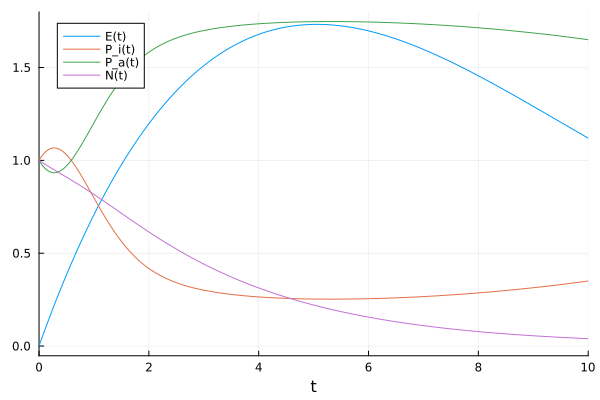

In [5]:
using OrdinaryDiffEq, Plots

u0 = [:N => 1.0, :E => 0.0, :P_i => 1.0, :P_a => 1.0]
tspan = (0.0, 10.0)
ps = [:v => 1.0, :K => 0.2, :d => 0.3, :kA => 2.0, :kD => 0.5, :r => 0.2]

oprob = ODEProblem(bacteria_in_nutrient, u0, tspan, ps)
sol = solve(oprob, Tsit5())
plot(sol)
